In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import json
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### Z TS
$$Z_{t} = Ln\left (\frac{S_{t}}{\widehat{S_{t}}}\right )$$

In [2]:
#Load residuals as z and set index as datetime
z_df = pd.read_json('inputs_json/residuals_stack.json', orient='index')

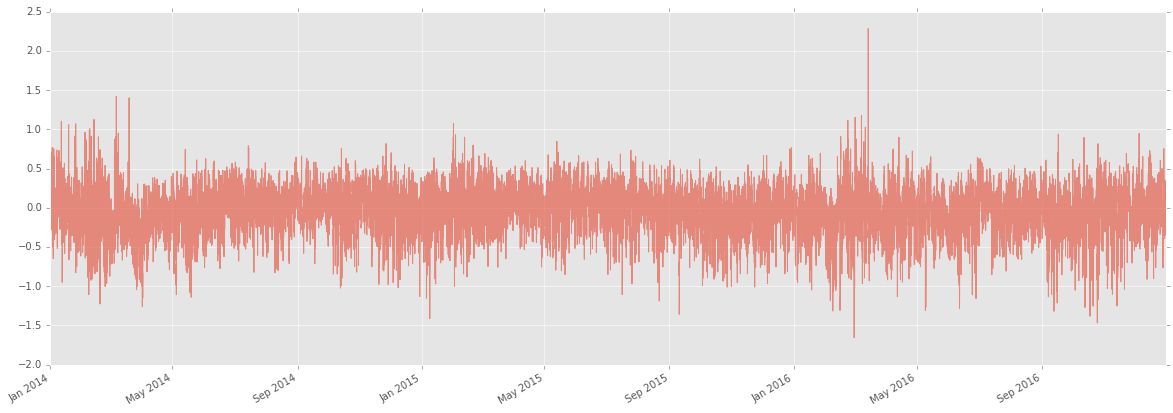

In [3]:
#Plot Z TS
fig, ax0 = plt.subplots(1,1, figsize=(20,7))
z_df['residuals'].plot(ax=ax0, alpha=0.6);

### Dick-Fuller test on stationarity

In [4]:
from statsmodels.tsa.stattools import adfuller

In [5]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [6]:
perform_stationarity_test(z_df['residuals'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.615692e+01
p-value                       4.507914e-29
#Lags used                    4.900000e+01
Number of observation used    2.625100e+04
Critical value (10%)         -2.566829e+00
Critical value (5%)          -2.861650e+00
Critical value (1%)          -3.430599e+00
dtype: float64


### ACF and PACF

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [9]:
def computer_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries, nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name = 'Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    #ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    #ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    #ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    #ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

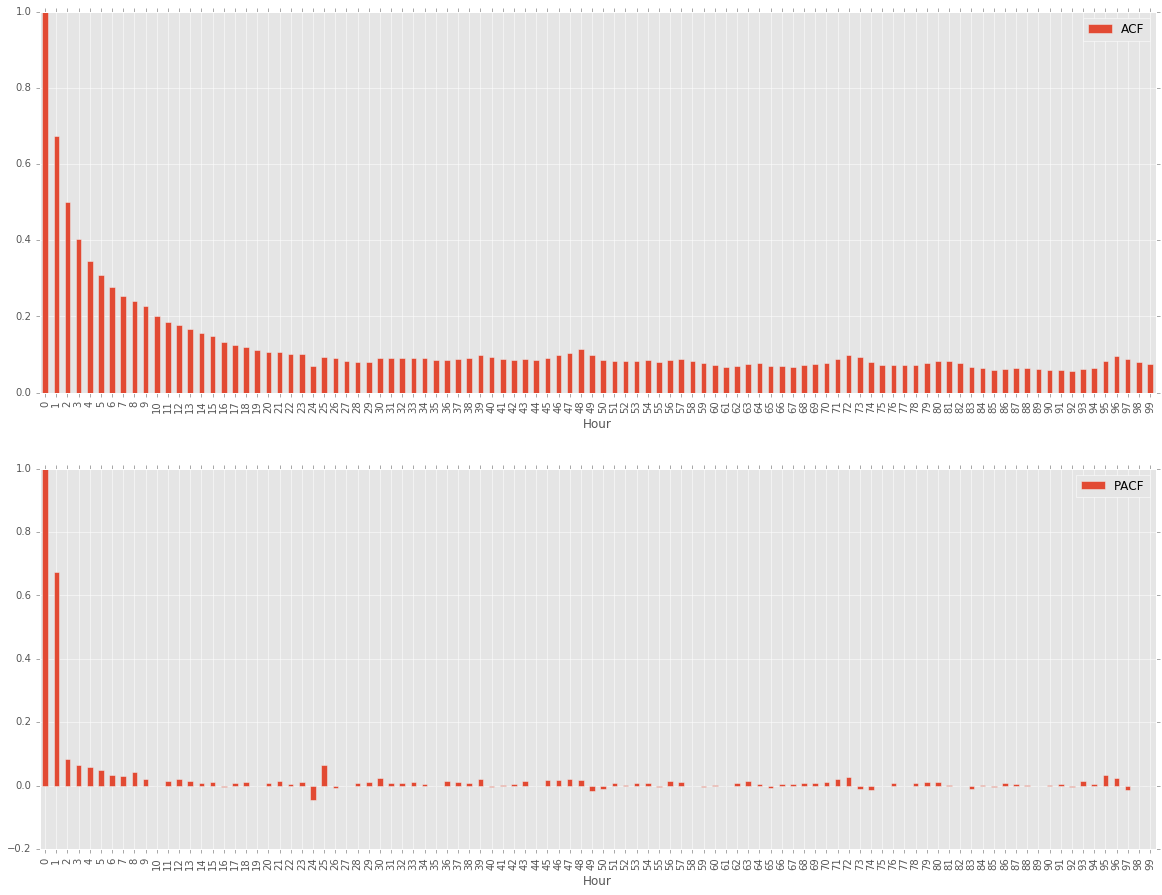

In [10]:
#ACF and PACF suggest an AR model with p = 24, since Hour 0 to 23 cannot be used
computer_acf_pacf(z_df['residuals'], 720, 720)

### ARIMA model, p=24

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [14]:
ar = np.zeros(24)

In [15]:
ar[-1] = 1

In [16]:
ar

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [17]:
model = SARIMAX(endog=z_df['residuals'].values, order=(ar,0,0))

In [18]:
%%time
results = model.fit(maxiter=400, disp=-1)

Wall time: 9.4 s


In [19]:
print(results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                26301
Model:             SARIMAX((24,), 0, 0)   Log Likelihood               -4940.359
Date:                  Sun, 26 Mar 2017   AIC                           9884.718
Time:                          18:37:40   BIC                           9901.073
Sample:                               0   HQIC                          9889.999
                                - 26301                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L24         0.0885      0.005     17.129      0.000       0.078       0.099
sigma2         0.0852      0.001    145.789      0.000       0.084       0.086
Ljung-Box (Q):                    39

In [20]:
results.resid.std()

0.28964225818241052

In [21]:
def compute_SARIMAX_model(timeseries, p, d, q):
    """
    Computes the SARIMAX model for a given timeseries with order p, d, q
    """
    model = SARIMAX(endog=timeseries.values, order=(p,d,q))
    fitted_model = model.fit(disp=-1, maxiter=400)
    return fitted_model

In [22]:
def check_cv_fold(timeseries, train_index, test_index, p, d, q):
    """
    Computes the 24-hour following error for an specific CV fold 
    """
    model = compute_SARIMAX_model(timeseries.iloc[train_index], p, d, q)
    y_pred = model.forecast(steps=24)
    y_true = timeseries.iloc[test_index].values[:24]
    error = mean_squared_error(y_true, y_pred)
    train_residuals = np.mean(model.resid**2)
    print('train length: %d, train MSE %.4f, test MSE %.4f' %(len(train_index), train_residuals, error))
    return train_residuals, error

In [23]:
%%time
tscv = TimeSeriesSplit(n_splits=10)
train_error = list()
test_error = list()
for train_index, test_index in tscv.split(z_df['residuals'].values):
    tr_error, ts_error = check_cv_fold(z_df['residuals'], train_index, test_index, ar, 0, 0)
    train_error.append(tr_error)
    test_error.append(ts_error)
print('CV Train MSE: %.4f, Test MSE: %.4f' %(np.mean(train_error), np.mean(test_error)))

train length: 2391, train MSE 0.1231, test MSE 0.0364
train length: 4782, train MSE 0.1004, test MSE 0.1156
train length: 7173, train MSE 0.0853, test MSE 0.0986
train length: 9564, train MSE 0.0842, test MSE 0.0853
train length: 11955, train MSE 0.0804, test MSE 0.1783
train length: 14346, train MSE 0.0784, test MSE 0.2098
train length: 16737, train MSE 0.0783, test MSE 0.0719
train length: 19128, train MSE 0.0831, test MSE 0.2005
train length: 21519, train MSE 0.0844, test MSE 0.0373
train length: 23910, train MSE 0.0837, test MSE 0.0641
CV Train MSE: 0.0881, Test MSE: 0.1098
Wall time: 44.5 s


In [24]:
fitted_model = compute_SARIMAX_model(z_df['residuals'], ar, 0, 0)

In [25]:
fitted_model.arparams

array([ 0.08849107,  0.08524384])

In [26]:
fitted_model.resid.std()

0.28964225818241052

$$Z_{t} = \alpha_{24} \cdot Z_{t-24} + \epsilon _{t}$$

$$\epsilon _{t} \sim N(0, \sigma _{x} ^{2})$$

In [27]:
#Export armaparams into a json
arima_parameters ={
    'ar':fitted_model.arparams.tolist()[0],
    'std':fitted_model.resid.std()
}

with open('inputs_json/arima_band_parameters_stack_model.json', 'w') as f:
     json.dump(arima_parameters, f)